2. **Tests unitarios de `core_distance`**: Implementa pruebas que verifiquen que:

   * Cuando `distances` tiene menos elementos que `min_points`, retorna `None`.
   * Cuando hay al menos `min_points` distancias, devuelve correctamente la k-ésima menor.



In [147]:
def core_distance(distances, min_points):
    if len(distances) < min_points:
        return None
    return sorted(distances)[min_points - 1]

import unittest
import random

class TestOPTICS(unittest.TestCase):
    def test_core_distance_none(self):
        self.assertIsNone(core_distance([0.1, 0.2], 3))
    def test_core_distance_value(self):
        self.assertEqual(core_distance([0.3, 0.1, 0.5, 0.2, 0.4], 3), 0.3)


In [148]:
# Ejecuta las pruebas
suite = unittest.TestLoader().loadTestsFromTestCase(TestOPTICS)
unittest.TextTestRunner(verbosity=2).run(suite) 


test_core_distance_none (__main__.TestOPTICS) ... ok
test_core_distance_value (__main__.TestOPTICS) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

3. **Optimización de la actualización del heap**: Refactoriza la función `update` para actualizar la prioridad en el heap de semillas sin usar `heapq.heapify`, por ejemplo usando una estructura de datos con actualización de clave más eficiente.


In [149]:
from d_heap import DWayHeap
from optics import *

In [150]:
C5 = (
        create_spherical_cluster((-2, 0), 2, 50) +
        create_spherical_cluster((2, 2), 0.5, 20) +
        create_spherical_cluster((2, 0.78), 0.25, 10)
    )

In [ ]:
def optics(points: List[Tuple[float, float]], eps: float, min_points: int, heap) -> Tuple[List[Optional[float]], List[int]]:
    """
    Ejecuta OPTICS sobre los puntos dados.

    Parámetros:
        points: lista de tuplas (x, y) con las coordenadas de los puntos.
        eps: radio máximo para considerar vecinos.
        min_points: número mínimo de puntos para definir un punto core.

    Retorna:
        reachability_distances: lista con la distancia de alcanzabilidad de cada punto (None si es noise o border).
        ordering: orden en que los puntos fueron procesados.
    """
    
    def core_distance(distances: List[float]) -> Optional[float]:
        # Si hay menos vecinos que min_points, no hay distancia core.
        if len(distances) < min_points:
            return None
        # La distancia core es la (min_points-ésima) menor distancia.
        return sorted(distances)[min_points - 1]

    
    def update(neighbors: List[int], distances: List[float], heap: DWayHeap):
        # Calcula la distancia core del punto actual.
        core_dist = core_distance(distances)
        if core_dist is None:
            return 

        # Para cada vecino, actualiza su distancia de alcanzabilidad.
        for q, dist in zip(neighbors, distances):
            if not processed[q]:
                # La nueva reachability es el máximo entre core_dist y la distancia al vecino.
                new_r = max(core_dist, dist)
                old_r = reachability_distances[q]
                if old_r is None or new_r < old_r:
                    # Si no tenía valor previo, se asigna y se agrega a la semilla.
                    reachability_distances[q] = new_r
                    heap.insert(q, -new_r)
                    
    n = len(points)
    processed = [False] * n
    reachability_distances: List[Optional[float]] = [None] * n
    tree = KDTree(points)
    ordering: List[int] = []

    # Recorre todos los puntos.
    for p in range(n):
        if processed[p]:
            continue
        processed[p] = True

        # Encuentra todos los vecinos dentro del radio eps.
        nbrs = tree.query_ball_point(points[p], r=eps)
        # Calcula distancias reales a cada vecino.
        nbr_dists = [math.dist(points[p], points[q]) for q in nbrs]
        # Si el punto es core (tiene core_distance), inicia expansión.
        if core_distance(nbr_dists) is not None:
            ordering.append(p)
            update(nbrs, nbr_dists, heap)
            
            while not heap.is_empty():
                q = heap.top()
                if processed[q]:
                    continue
                processed[q] = True
                ordering.append(q)

                # Expande desde el nuevo punto q.
                q_nbrs = tree.query_ball_point(points[q], r=eps)
                q_dists = [math.dist(points[q], points[i]) for i in q_nbrs]
                if core_distance(q_dists) is not None:
                    update(q_nbrs, q_dists, heap)
        else:
            # Punto border o noise: distancia de alcanzabilidad indefinida.
            reachability_distances[p] = None

    return reachability_distances, ordering


In [152]:
heap = DWayHeap(branching_factor=2)
heap.insert(0, 5) #valor , prioridad
heap.insert(1, 20)
while not heap.is_empty():
   print(heap.top())


1
0


In [153]:
heap = DWayHeap(branching_factor=2)
#heap.insert(0, 5) //valor , prioridad
#while not heap.is_empty():
#   print(heap.top())
reachability_distances, ordering = optics(points=C5, eps=2.0, min_points=5, heap=heap)


Generando gráficos para eps = 0.2


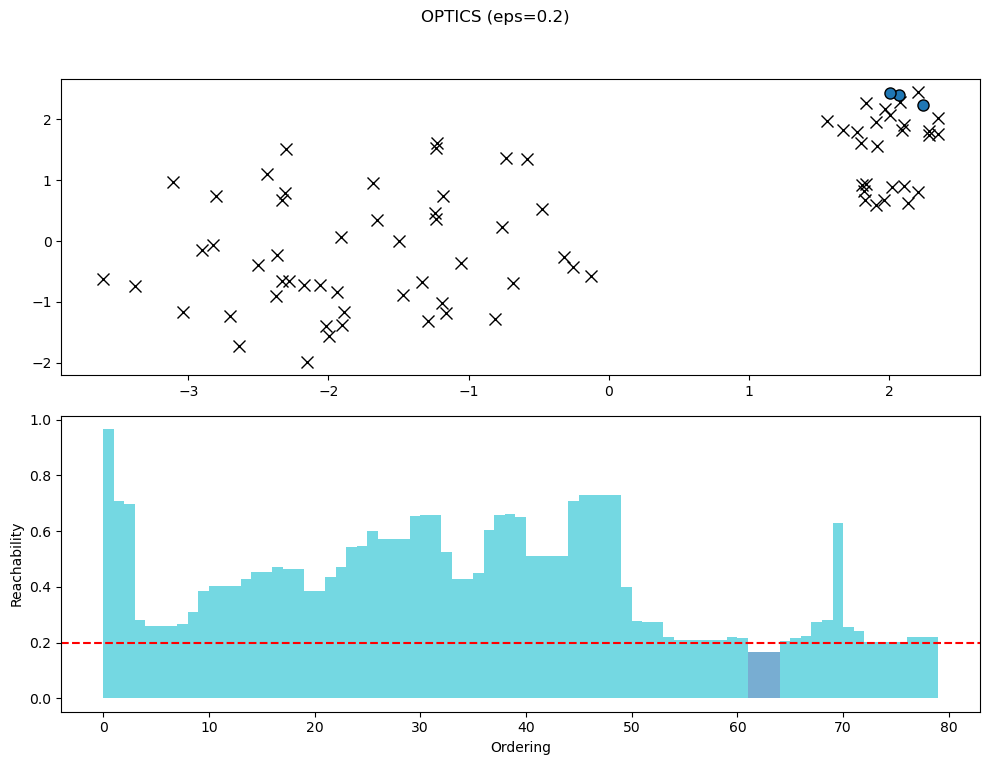


Generando gráficos para eps = 0.4


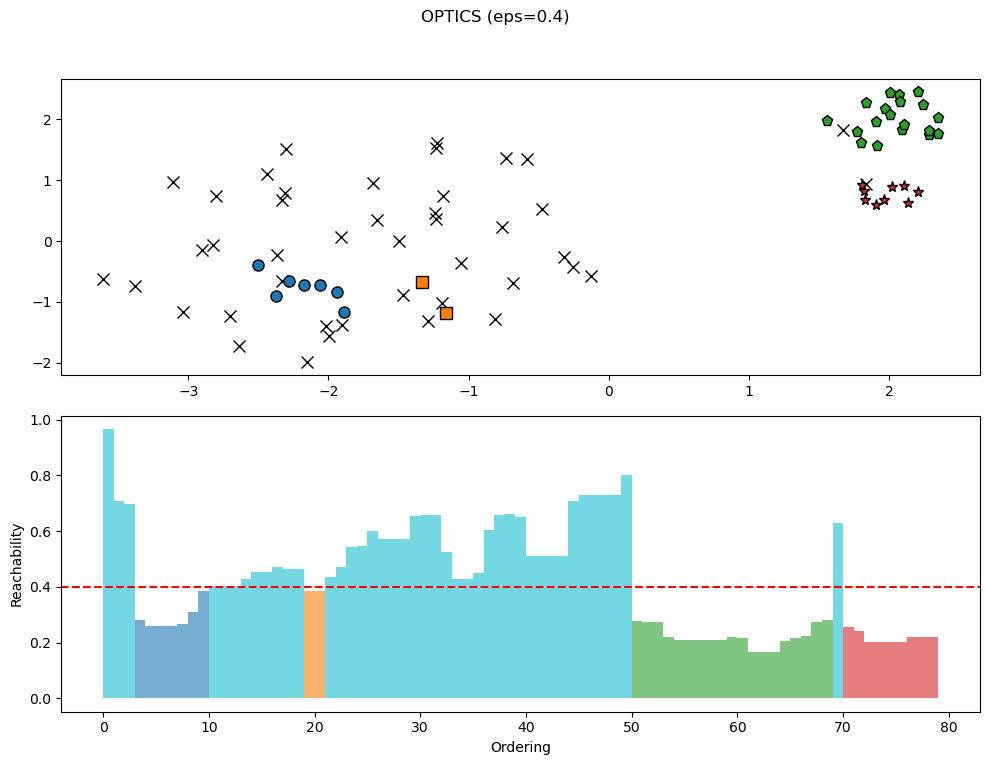


Generando gráficos para eps = 0.6


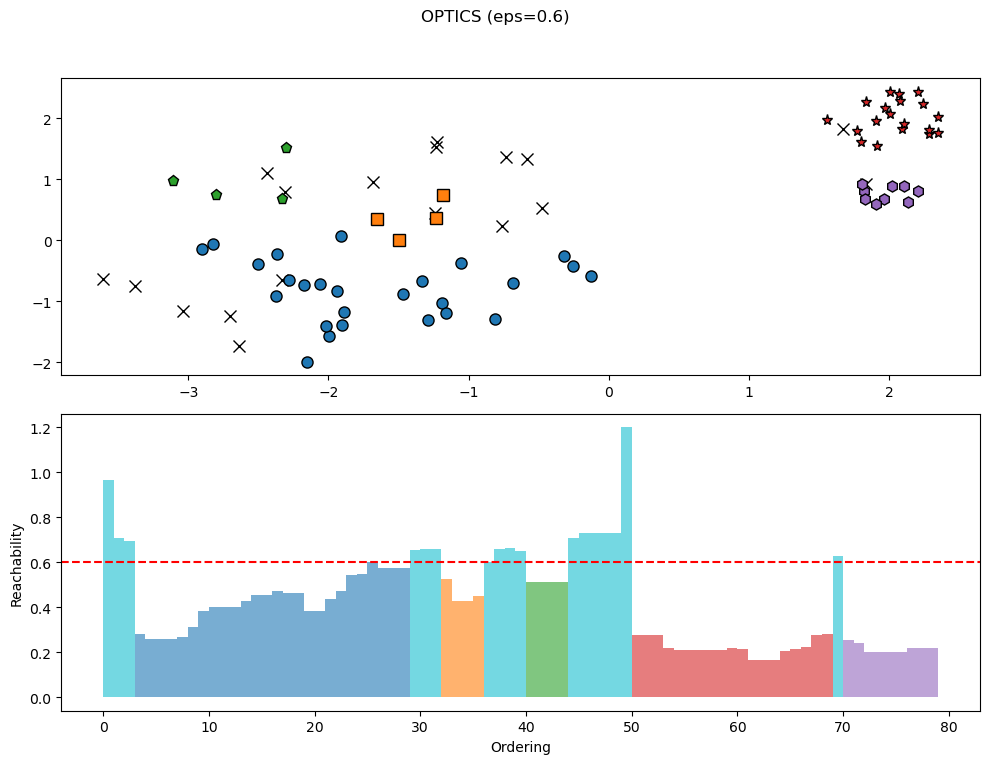


Generando gráficos para eps = 0.8


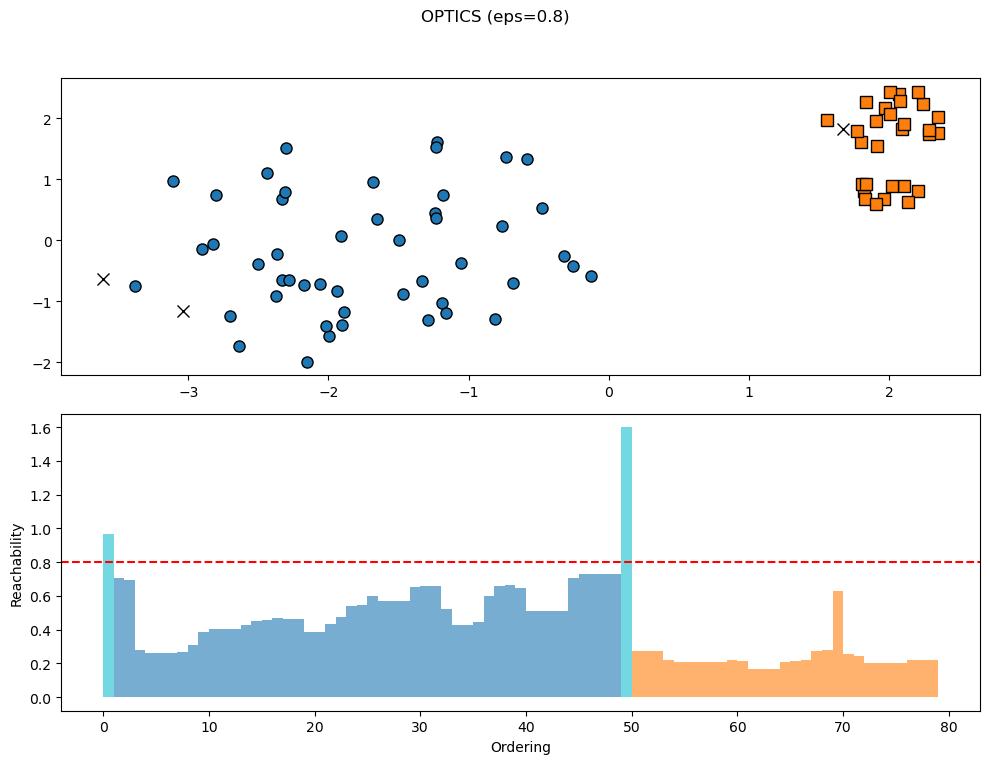

In [154]:
for eps in [0.2, 0.4, 0.6, 0.8]:
    print(f"\nGenerando gráficos para eps = {eps}")
    reachability_plot(C5, ordering, reachability_distances, eps)

4. **Umbrales variables por punto**: Modifica `optics_to_clusters` para aceptar un vector de umbrales `eps_i` distinto para cada punto, en lugar de un único `eps` global, y analiza el impacto en la formación de clusters.


Clusterizaremos dando un enfoque donde  la distancia  es a lo mas ``k`` veces del promedio de sus ``r`` primeros puntos  mas cercanos en el cluster.

In [155]:
inf = 100000
def optics_to_clusters(ordering: List[int], reachability_distances: List[Optional[float]], l_first_group: int, tasa_crecimiento : float):
    n = len(ordering)
    labels = [NOISE] * len(ordering)
    cluster_id = 0

    for idx in range(n):
        point = ordering[idx]
        r = reachability_distances[point]
        
        # Euristica
        dis = 0.0
        tmp_idx = idx
        
        cnt = 0
        for i in range(l_first_group):
            near_point = ordering[tmp_idx]
            if reachability_distances[near_point] is None:
                dis = inf #Tenemos que pasar al siguiente cluster
                break
            dis += reachability_distances[near_point]
            tmp_idx += 1
            cnt += 1
            if(tmp_idx >= n):
                break
        average_distance = dis / cnt if cnt > 0 else inf
        eps = average_distance * tasa_crecimiento
        # Final de la euristica
        
        if r is None or r > eps:
            # Iniciar un nuevo clúster solo si el punto anterior pertenecía a un clúster
            if idx > 0:
                prev = ordering[idx - 1]
                if reachability_distances[prev] is not None and reachability_distances[prev] <= eps:
                    cluster_id += 1
            labels[point] = NOISE
        else:
            labels[point] = cluster_id

    return labels


In [156]:
def plot_clusters(points: List[Tuple[float, float]], labels: List[int], ax):
    clusters = groupby(sorted(range(len(points)), key=lambda i: labels[i]), key=lambda i: labels[i])
    unique = sorted(set(labels))
    colors = ['k'] + list(mcolors.TABLEAU_COLORS.keys())
    markers = ['x', 'o', 's', 'p', '*', 'h', 'H', 'X', 'D', 'd']
    for label, group in clusters:
        pts = [points[i] for i in group]
        xs, ys = zip(*pts)
        color = colors[unique.index(label) % len(colors)]
        marker = markers[unique.index(label) % len(markers)]
        ax.plot(xs, ys, linestyle='none', marker=marker, markersize=8,
                markerfacecolor=color, markeredgecolor='k')

In [157]:
def plot_reachability(ax, ordering: List[int], reachability_distances: List[Optional[float]], labels: List[int], eps: float):
    rd = [d if d is not None else 2*eps for d in reachability_distances]
    xs = list(range(len(ordering)))
    # fill per-cluster
    for lbl in sorted(set(labels)):
        ys = [rd[ordering[i]] if labels[ordering[i]] == lbl else 0 for i in xs]
        color = mcolors.TABLEAU_COLORS[list(mcolors.TABLEAU_COLORS.keys())[lbl % len(mcolors.TABLEAU_COLORS)]]
        ax.fill_between(xs, 0, ys, facecolor=color, step='pre', alpha=0.6)
    ax.axhline(eps, color='r', linestyle='--')
    ax.set_ylabel('Reachability')
    ax.set_xlabel('Ordering')

In [158]:
def reachability_plot(points: List[Tuple[float, float]], ordering: List[int],
                      reachability_distances: List[Optional[float]], l_first_group: float = 3, tasa_crecimiento: float = 1):
    labels = optics_to_clusters(ordering, reachability_distances, l_first_group=l_first_group, tasa_crecimiento=tasa_crecimiento)
    fig, ax1  = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle(f'OPTICS (l_first_group={l_first_group}, tasa_crecimiento={tasa_crecimiento})')
    plot_clusters(points, labels, ax1)



Generando gráficos para l_first_group = 3, tasa_crecimiento = 1.1

Generando gráficos para l_first_group = 3, tasa_crecimiento = 1.5

Generando gráficos para l_first_group = 3, tasa_crecimiento = 2

Generando gráficos para l_first_group = 4, tasa_crecimiento = 1.1

Generando gráficos para l_first_group = 4, tasa_crecimiento = 1.5

Generando gráficos para l_first_group = 4, tasa_crecimiento = 2


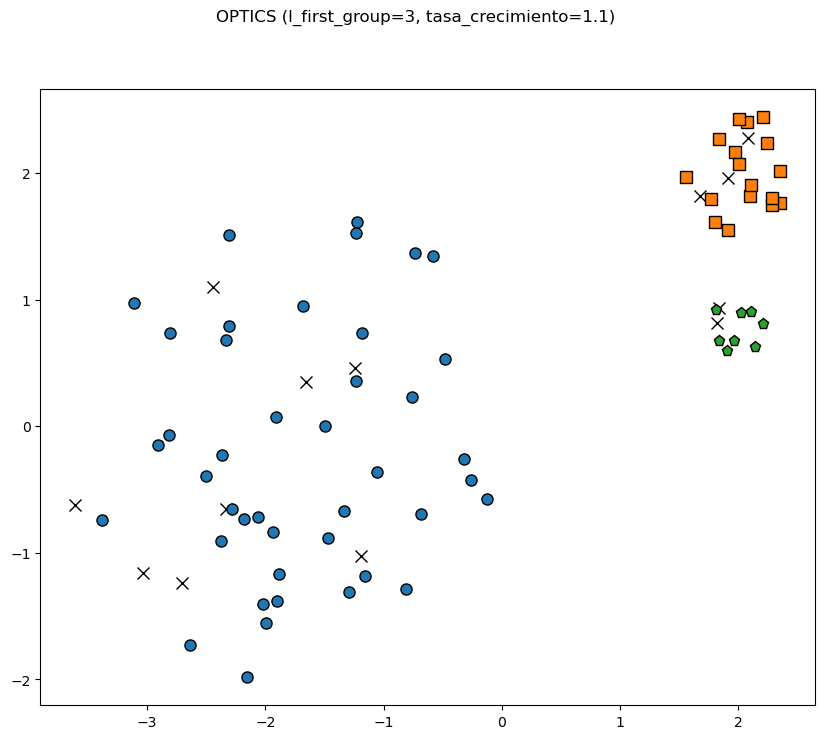

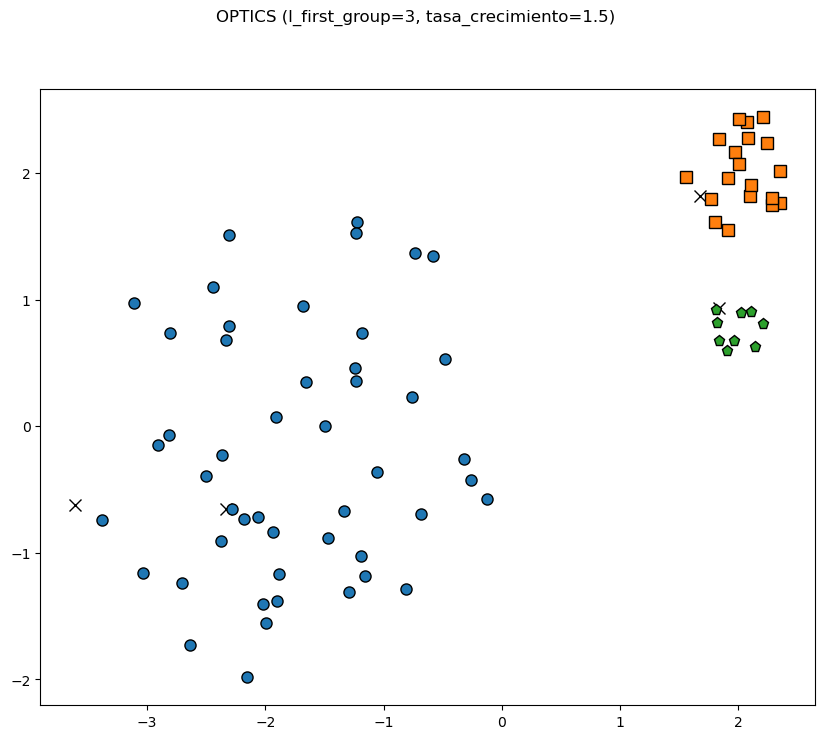

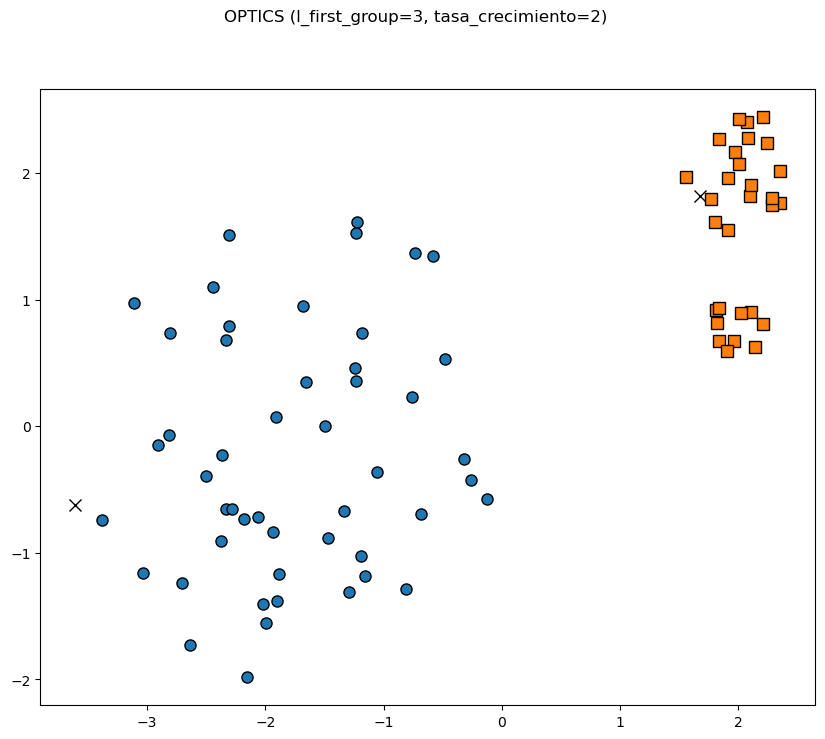

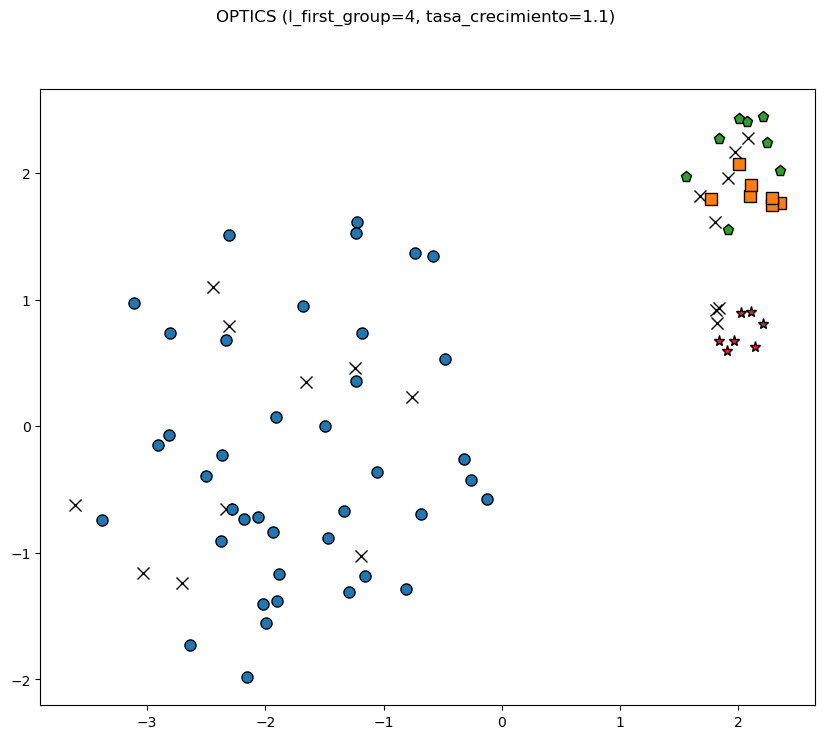

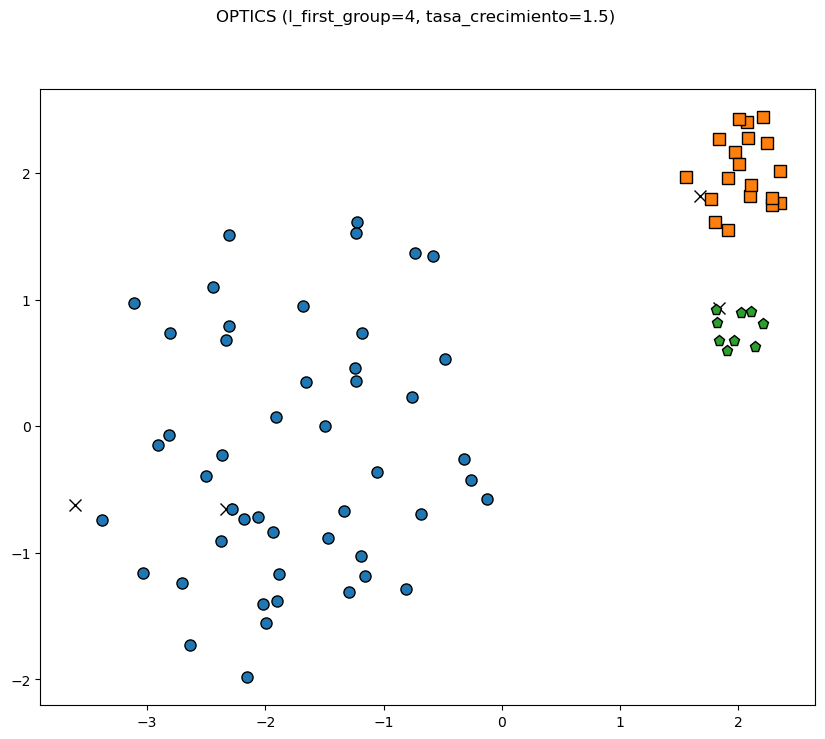

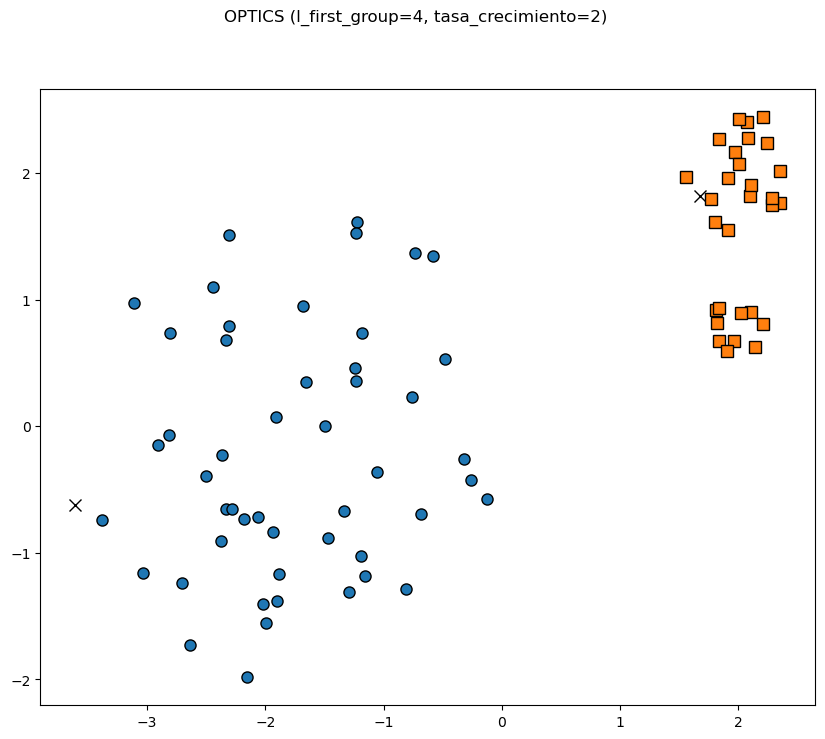

In [159]:

params = [(3, 1.1), (3, 1.5), (3, 2), (4, 1.1), (4, 1.5), (4, 2)]
for l_first_group, tasa_crecimiento in params:
    print(f"\nGenerando gráficos para l_first_group = {l_first_group}, tasa_crecimiento = {tasa_crecimiento}")
    reachability_plot(C5, ordering, reachability_distances, l_first_group=l_first_group, tasa_crecimiento=tasa_crecimiento)
